# Imports

In [85]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

# Dataset cleaning (all features need to be numeric)

In [86]:
df = pd.read_csv('complete_df_with_predictions.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [87]:
df.dtypes

Unnamed: 0           int64
decile3            float64
ID                   int64
decile1            float64
race               float64
lsat               float64
ugpa               float64
zfygpa             float64
grad                 int64
zgpa               float64
bar1                 int64
bar1_yr            float64
bar2                 int64
bar2_yr            float64
fam_inc            float64
parttime           float64
male               float64
race2               object
pass_bar             int64
bar                 object
tier               float64
academic_career    float64
race1_black           bool
race1_hisp            bool
race1_other           bool
race1_white           bool
race1               object
dtype: object

In [88]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])
df

,Unnamed: 0,decile3,ID,decile1,race,lsat,ugpa,zfygpa,grad,zgpa,...,pass_bar,bar,tier,academic_career,race1_black,race1_hisp,race1_other,race1_white,race1,race1_encoded
0,0,10.0,2,10.0,7.0,44.0,3.5,1.33,1,1.88,...,1,a Passed 1st time,4.0,1.341087,False,False,False,True,white,4
1,1,4.0,3,5.0,7.0,29.0,3.5,-0.11,1,-0.57,...,1,a Passed 1st time,2.0,-0.385252,False,False,False,True,white,4
2,2,2.0,36,3.0,7.0,36.0,3.5,-0.64,1,-1.12,...,1,a Passed 1st time,3.0,-0.355093,False,False,False,True,white,4
3,3,4.0,52,7.0,7.0,39.0,3.5,0.34,1,-0.49,...,1,a Passed 1st time,3.0,0.217453,False,False,False,True,white,4
4,4,8.0,55,9.0,7.0,48.0,3.5,1.02,1,0.76,...,1,a Passed 1st time,5.0,1.144843,False,False,False,True,white,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,22402,1.0,10695,3.0,3.0,26.5,1.8,-0.58,1,-1.49,...,0,c Failed,1.0,-1.922560,True,False,False,False,black,1
22068,22403,1.0,19642,3.0,3.0,19.7,1.8,-0.64,1,-1.36,...,0,c Failed,1.0,-2.216261,True,False,False,False,black,1
22069,22404,8.0,24704,7.0,3.0,36.0,1.8,0.41,1,0.80,...,1,a Passed 1st time,3.0,-0.613914,True,False,False,False,black,1
22070,22405,10.0,10000,10.0,7.0,44.0,1.5,1.88,1,1.42,...,1,a Passed 1st time,3.0,0.134185,False,False,False,True,white,4


In [89]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]
df.dtypes

decile3            float64
decile1            float64
pass_bar             int64
tier               float64
parttime           float64
ID                   int64
bar1                 int64
race1_encoded        int32
race1_black           bool
academic_career    float64
race1_other           bool
bar1_yr            float64
bar2                 int64
race1_hisp            bool
zgpa               float64
zfygpa             float64
bar2_yr            float64
lsat               float64
Unnamed: 0           int64
race1_white           bool
fam_inc            float64
male               float64
grad                 int64
ugpa               float64
race               float64
dtype: object

# Split Train and Test

In [90]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [91]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

# Apply Techniques to train

In [92]:
import pandas as pd
import numpy as np

def compute_reweighing_weights(df, label_col, protected_attr_col):
    df = df.copy()
    
    # Get joint and marginal probabilities
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']
    
    # Merge probabilities
    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)
    
    # Compute weight: P(A) * P(Y) / P(A, Y)
    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))
    
    # Merge weights back to original dataframe
    df = df.merge(weights_df[[protected_attr_col, label_col, 'weight']],
                  on=[protected_attr_col, label_col],
                  how='left')
    
    return df

df_train_weighted = compute_reweighing_weights(df_train, label_col=target, protected_attr_col='race1_encoded')

print(df_train_weighted[['race1_encoded', f'{target}', 'weight']].head())


   race1_encoded  pass_bar    weight
0              4         1  0.981218
1              4         1  0.981218
2              4         1  0.981218
3              4         1  0.981218
4              4         1  0.981218


In [93]:
X_train_weighted = df_train_weighted[features]
y_train_weighted = df_train_weighted[target]

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


fbeta_scorer = make_scorer(fbeta_score, beta=1.41, pos_label=0)

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 8, 10, None],
    'min_samples_split': [2, 5, 10]
}

clf = GridSearchCV(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2),
    param_grid,
    scoring=fbeta_scorer,  
    cv=5
)
clf.fit(X_train_weighted, y_train_weighted)

print("Best max_depth:", clf.best_params_['max_depth'])
print("Best min_samples_split:", clf.best_params_['min_samples_split'])

Best max_depth: 8
Best min_samples_split: 5


In [96]:
from sklearn.metrics import classification_report, confusion_matrix


rf_best_model = clf.best_estimator_

rf_y_pred = rf_best_model.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

[[ 165   62]
 [ 683 3505]]
              precision    recall  f1-score   support

           0       0.19      0.73      0.31       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.59      0.78      0.61      4415
weighted avg       0.94      0.83      0.87      4415



# Apply techniques to whole dataset

In [97]:
# import pandas as pd
# import numpy as np

# def compute_reweighing_weights(df, label_col, protected_attr_col):
#     df = df.copy()
    
#     # Get joint and marginal probabilities
#     joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
#     attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
#     attr_counts.columns = [protected_attr_col, 'attr_prob']
#     label_counts = df[label_col].value_counts(normalize=True).reset_index()
#     label_counts.columns = [label_col, 'label_prob']
    
#     # Merge probabilities
#     weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
#     weights_df = weights_df.merge(label_counts, on=label_col)
    
#     # Compute weight: P(A) * P(Y) / P(A, Y)
#     weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))
    
#     # Merge weights back to original dataframe
#     df = df.merge(weights_df[[protected_attr_col, label_col, 'weight']],
#                   on=[protected_attr_col, label_col],
#                   how='left')
    
#     return df

# df_weighted_1 = compute_reweighing_weights(df, label_col=target, protected_attr_col='race1_encoded')
# df_weighted_2 = compute_reweighing_weights(df_weighted_1, label_col=target, protected_attr_col='tier')
# df_weighted = compute_reweighing_weights(df_weighted_2, label_col=target, protected_attr_col='fam_inc')

# print(df_weighted[['race1_encoded', f'{target}', 'weight']].head())

In [98]:
def compute_individual_weights(df, label_col, protected_attr_col):
    # Compute weights for one protected attribute
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']  # Multiply in the new weight

    return df


In [99]:
protected_attributes = ['race1_encoded', 'tier', 'fam_inc']
df_weighted = compute_combined_weights(df, label_col=target, protected_attrs=protected_attributes)


In [100]:
pass_bar_rf_race = rf_best_model.predict(df_weighted[features])
df['pass_bar_rf_weighted'] = pass_bar_rf_race

C:\Users\annad\AppData\Local\Temp\ipykernel_11720\1965024977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pass_bar_rf_weighted'] = pass_bar_rf_race


# Check for bias

In [101]:
df_clean = df.dropna().copy()
df['race1'] = df_copied['race1']
df["race1"].unique()

C:\Users\annad\AppData\Local\Temp\ipykernel_11720\1558422169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race1'] = df_copied['race1']


array(['white', 'hisp', 'asian', 'black', 'other'], dtype=object)

In [102]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf_weighted', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf_weighted', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf_weighted'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }

C:\Users\annad\AppData\Local\Temp\ipykernel_11720\262870205.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

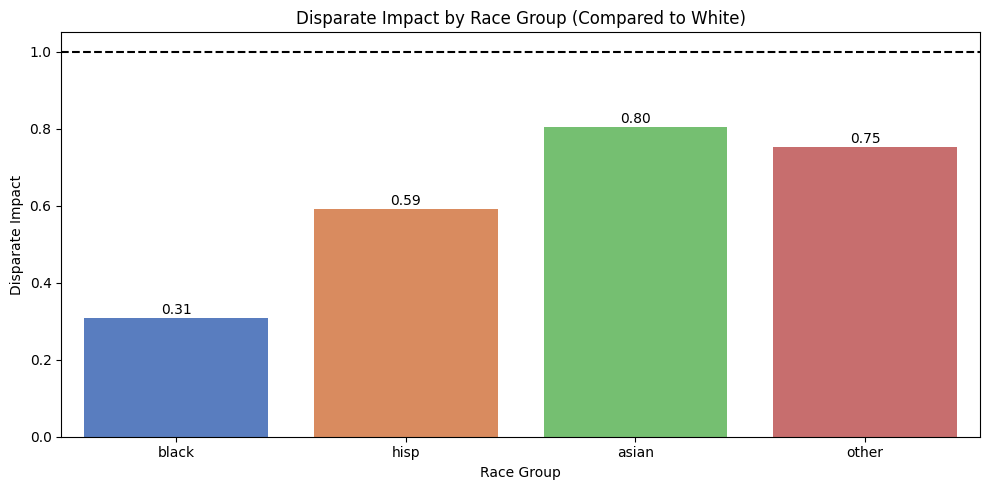

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


C:\Users\annad\AppData\Local\Temp\ipykernel_11720\554246687.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

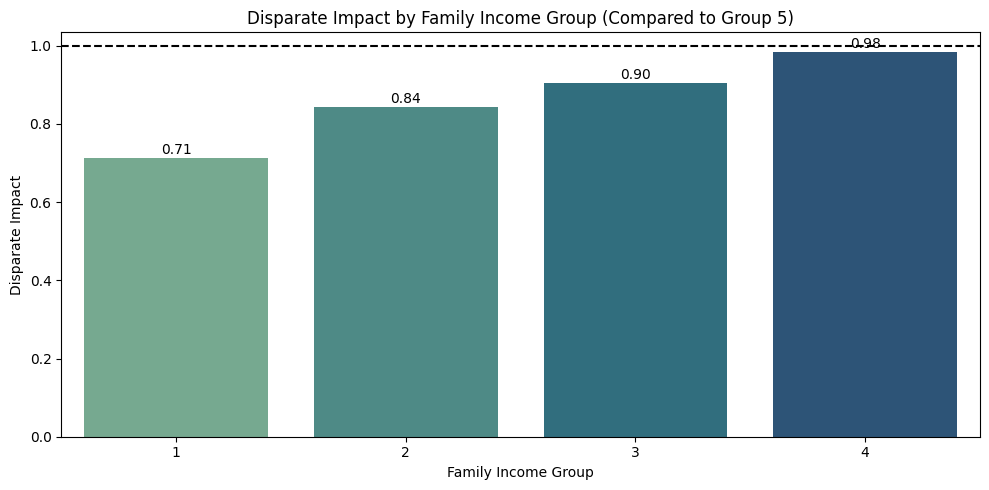

In [104]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf_weighted', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf_weighted', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf_weighted'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()




C:\Users\annad\AppData\Local\Temp\ipykernel_11720\3642827210.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group

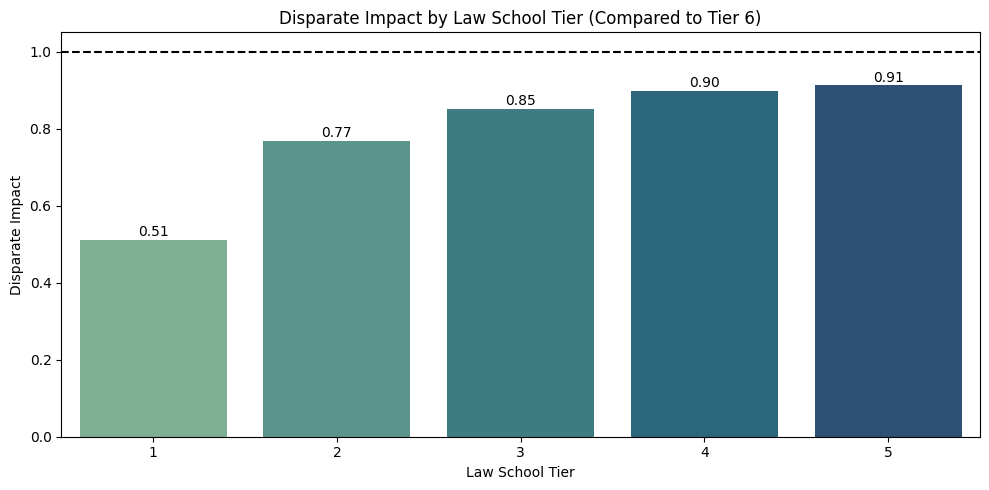

In [105]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf_weighted', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf_weighted', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf_weighted'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()
